# TDM MIMO

## TDM MIMO ULA

## Setup

In [14]:
# Install a pip package in the current Jupyter kernel
import sys
from os.path import abspath, basename, join, pardir
import datetime

# hack to handle if running from git cloned folder or stand alone (like Google Colab)
cw = basename(abspath(join(".")))
dp = abspath(join(".",pardir))
if cw=="docs" and basename(dp) == "mmWrt":
    # running from cloned folder
    print("running from git folder, using local path (latest) mmWrt code", dp)
    sys.path.insert(0, dp)
else:
    print("running standalone, need to ensure mmWrt is installed")
    !{sys.executable} -m pip install mmWrt

from os.path import abspath, join, pardir
import sys
from numpy.fft import fft, fftshift
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from numpy import arange, cos, sin, pi, zeros

from mmWrt.Scene import Antenna, Medium, Radar, Receiver, Target, Transmitter
from mmWrt.Raytracing import rt_points
from mmWrt import __version__
print("version:", __version__)

print(datetime.datetime.now())

running from git folder, using local path (latest) mmWrt code c:\git\mmWrt
version: 0.0.7
2024-10-23 14:12:01.437138


??1 (64, 64)
??2 (64, 64)


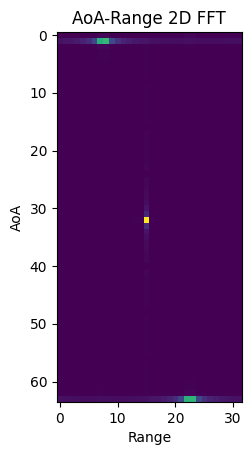

In [15]:
f0 = 62e9
# Number of ADC samples
NA = 64
# Number of TX channels
NT = 8
# Number of RX channels
NR = 8

void = Medium()
c = void.v
lambda0 = c/f0
_fs = 4e3
_k = 70e8
TXs = [Antenna(x=NR*lambda0/2*i) for i in range(NT)]
RXs = [Antenna(x=lambda0/2*i) for i in range(NR)]

radar = Radar(transmitter=Transmitter(bw=3.5e9, slope=_k,
                                      antennas=TXs),
              receiver=Receiver(fs=_fs, max_adc_buffer_size=2048,
                                n_adc=NA,
                                antennas=RXs),
              debug=False)
r1, theta1 = 10.1, 0
x1, y1 = r1*cos(theta1), r1*sin(theta1)
r2, theta2 = 20.1, pi/2
x2, y2 = r2*cos(theta2), r2*sin(theta2)
r3, theta3 = 30.1, pi
x3, y3 = r3*cos(theta3), r3*sin(theta3)

target1 = Target(x1, y1, 0)  # 0 degrees on x-axis <=> -pi/2 vs bore sight
target2 = Target(x2, y2, 0) # pi/2 degrees vs x-ax <=> 0 degree vs bore sight
target3 = Target(x3, y3, 0) # 180 degrees on x-axis <=> pi/2 vs boresight
targets = [target1, target2, target3]

bb = rt_points(radar, targets,
               debug=False)
cube = bb["adc_cube"]
# bb[frame_i, chirp_i, tx_i, rx_i, adc_i]

# generate virtual antennas
virtual_cube = zeros(( NT * NR, NA))
print("??1", virtual_cube.shape)
for tx_idx in range(NT):
    for rx_idx in range(NR):
        virtual_cube[tx_idx*NT+ rx_idx,:] = cube[:, :, tx_idx, rx_idx, :]

print("??2", virtual_cube.shape)

fast_time_axis = 1
RX_antennas_axis = 0
# first compute the range FFT
R_fft = fft(virtual_cube, axis=fast_time_axis)
# then compute the AoA FFT
A_FFT = fft(R_fft, axis=RX_antennas_axis)

# for Range vs AoA, display magnitude
# and need to fftshift to have the negative frequencies moved around 0
Z_fft = abs(fftshift(A_FFT[:,:], axes=0))
plt.xlabel("Range")
plt.ylabel("AoA")
plt.title('AoA-Range 2D FFT')
plt.imshow(Z_fft[:,:NA//2])

In [5]:
R_fft.shape

(1, 1, 8, 8, 64)